## Seasonality and Events

In this section, users will learn

1. modeling complex seasonality
2. modeling events

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM
from karpiu.utils import insert_events, extend_ts_features

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 50)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

Recall in quickstart, a demo on non-seasonal data is shown. This time the demo will use a exhibit yearly and weekly seasonal pattern with events.

In [3]:
RAW_DATA_FILE = "resource/seasonal/df.csv"
SCALABILITY_FILE = "resource/seasonal/scalability_df.csv"
ADSTOCK_FILE = "resource/seasonal/adstock_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [4]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])
scalability_df = pd.read_csv(SCALABILITY_FILE)
adstock_df = pd.read_csv(ADSTOCK_FILE, index_col="regressor")

Note that the one-hot-encoded dummies are already appended in the dataframe.

In [5]:
event_cols = [
    "new-years-day",
    "martin-luther-king-jr-day",
    "washingtons-birthday",
    "memorial-day",
    "independence-day",
    "labor-day",
    "columbus-day",
    "veterans-day",
    "veterans-day-observed",
    "thanksgiving",
    "christmas-day",
    "independence-day-observed",
    "juneteenth-national-independence-day-observed",
    "juneteenth-national-independence-day",
    "christmas-day-observed",
    "new-years-day-observed",
]

In [6]:
df.head(5)

,date,sales,promo,radio,search,social,tv,new-years-day,martin-luther-king-jr-day,washingtons-birthday,...,columbus-day,veterans-day,veterans-day-observed,thanksgiving,christmas-day,independence-day-observed,juneteenth-national-independence-day-observed,juneteenth-national-independence-day,christmas-day-observed,new-years-day-observed
0,2019-01-01,3302.00000,931.00000,6510.00000,0.00000,0.00000,0.00000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-02,767.00000,1197.00000,5609.00000,8893.00000,3381.00000,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-03,1034.00000,611.00000,2005.00000,0.00000,0.00000,2238.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-04,787.00000,976.00000,0.00000,3329.00000,3519.00000,2904.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-05,1758.00000,698.00000,2750.00000,0.00000,1915.00000,3288.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fitting a MMM

Since the model is using Fourier terms in fitting seasonality, fs_orders is also required.

In [7]:
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=event_cols,
    seed=2022,
    adstock_df=adstock_df,
    seasonality=[7, 365.25],
    fs_orders=[2, 3],
)

2023-02-22 23:01:01 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [8]:
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.0015,
    "slope_sm_input": 0.0015,
}
mmm.set_hyper_params(best_params)

2023-02-22 23:01:01 - karpiu-mmm - INFO - Set hyper-parameters.
2023-02-22 23:01:01 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-02-22 23:01:01 - karpiu-mmm - INFO - Best params level_sm_input set as 0.00150
2023-02-22 23:01:01 - karpiu-mmm - INFO - Best params slope_sm_input set as 0.00150


Fit the model with supplied dataframe.

Feel free to use more chains if the machine running the model has multiple cores.

In [9]:
mmm.fit(df, num_sample=100, num_warmup=400, chains=1)

2023-02-22 23:01:01 - karpiu-mmm - INFO - Fit final model.
2023-02-22 23:01:01 - karpiu-mmm - INFO - Deriving saturation constants...
2023-02-22 23:01:01 - karpiu-mmm - INFO - Derived saturation constants.
2023-02-22 23:01:01 - karpiu-mmm - INFO - Build a default regression scheme
2023-02-22 23:01:01 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 400 and samples(per chain): 100.


chain 1 |          | 00:00 Status

2023-02-22 23:02:42 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.58009569) is within common range (0, 0.8].


### Model Regression Coefficents

Now, we can see all the Fourier and event terms regression coefficient.

In [10]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.14876,0.06039,0.30112,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.08366,0.00005,0.15589,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.03986,0.02053,0.08973,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.30427,0.18639,0.41401,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.00355,0.00045,0.01938,1.00000,0.00000,0.00000,0.10000
5,s7_fs_cos1,Regular,0.04186,0.02157,0.06330,1.00000,0.00000,0.00000,0.30000
6,s7_fs_cos2,Regular,0.02465,0.00958,0.04072,1.00000,0.00000,0.00000,0.30000
7,s7_fs_sin1,Regular,-0.03376,-0.05817,-0.01482,0.00000,1.00000,0.00000,0.30000
8,s7_fs_sin2,Regular,0.00211,-0.01416,0.02606,0.57000,0.43000,0.00000,0.30000
9,s365.25_fs_cos1,Regular,0.15371,0.13767,0.17219,1.00000,0.00000,0.00000,0.30000


### Forecast Future Outcome

Prediction interval is not supported yet but will be available in future version. Here a demo of using `insert_event` and `extend_ts_features` are also shown to generate future dataframe for long-term forecast checking.

In [11]:
from orbit.diagnostics.plot import plot_predicted_data

In [12]:
future_df = extend_ts_features(df, 365, date_col="date")
future_df, event_cols = insert_events(future_df, date_col="date", country="US")

In [13]:
pred_df = mmm.predict(future_df)

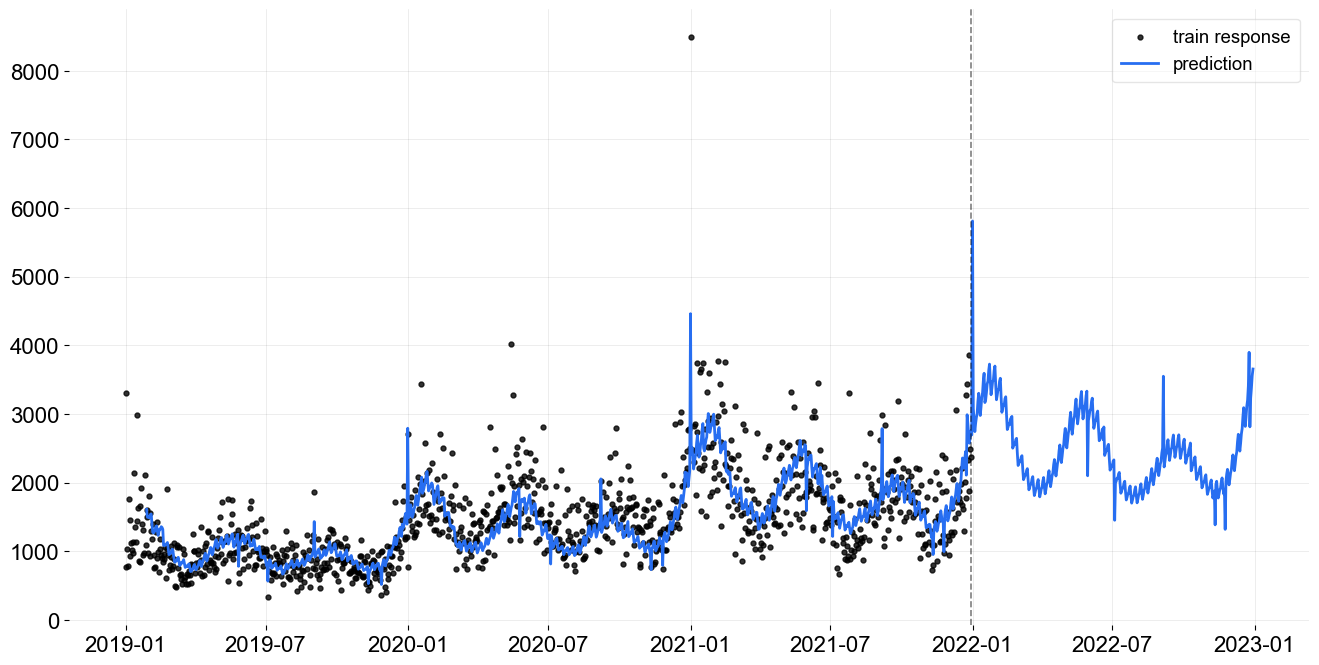

In [14]:
plot_predicted_data(
    training_actual_df=df,
    predicted_df=pred_df,
    date_col="date",
    actual_col="sales",
    # test_actual_df=test_df,
);